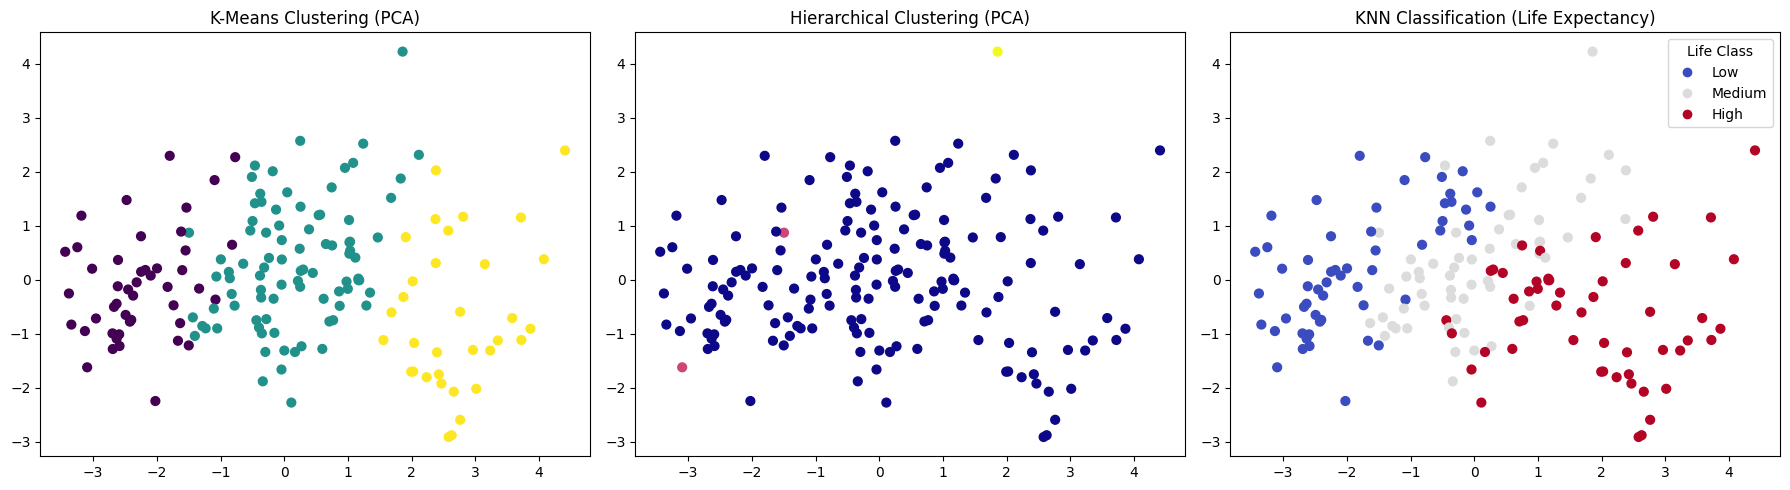


=== UNSUPERVISED (SILHOUETTE) ===
K-Means:      0.2567
Hierarchical: 0.1899

=== KNN CLASSIFICATION (LIFE EXPECTANCY) ===
Accuracy:  0.7904
Precision: 0.7920
Recall:    0.7910
F1-score:  0.7912

Confusion Matrix:
[[49  5  1]
 [ 7 40  9]
 [ 0 13 43]]

Life Expectancy Thresholds:
Low ≤ 68.13, Medium ≤ 76.00, High > 76.00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# 1. DATA PREPROCESSING
# =========================================================

def preprocess_data(filename, corr_threshold=0.95, z_clip=3):
    df = pd.read_csv(filename)

    life = df["life_expec"].values
    X = df.drop(["country", "life_expec"], axis=1)

    # Missing value imputation
    for col in X.columns:
        X[col] = X[col].fillna(X[col].mean())

    X = X.values.astype(float)

    # Outlier clipping (Z-score)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    z = (X - mean) / (std + 1e-8)
    X = np.where(np.abs(z) > z_clip, mean, X)

    # Remove low-variance features
    variances = np.var(X, axis=0)
    X = X[:, variances > 1e-4]

    # Remove highly correlated features
    corr = np.corrcoef(X.T)
    to_remove = set()
    for i in range(len(corr)):
        for j in range(i + 1, len(corr)):
            if abs(corr[i, j]) > corr_threshold:
                to_remove.add(j)

    if to_remove:
        keep = [i for i in range(X.shape[1]) if i not in to_remove]
        X = X[:, keep]

    # Standardization
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / (std + 1e-8)

    return X, life


# =========================================================
# 2. LIFE EXPECTANCY → 3 CLASSES
# =========================================================

def create_life_classes(life):
    q1 = np.percentile(life, 33)
    q2 = np.percentile(life, 66)

    y = np.zeros(len(life), dtype=int)
    y[life <= q1] = 0
    y[(life > q1) & (life <= q2)] = 1
    y[life > q2] = 2

    return y, (q1, q2)


# =========================================================
# 3. PCA (VISUALIZATION ONLY)
# =========================================================

def pca_scratch(X, n_components=2):
    cov = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    return X @ eigvecs[:, :n_components]


# =========================================================
# 4. DISTANCE FUNCTION
# =========================================================

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


# =========================================================
# 5. SILHOUETTE SCORE (SCRATCH)
# =========================================================

def silhouette_score_scratch(X, labels):
    scores = []

    for i in range(len(X)):
        same = X[labels == labels[i]]
        other = [X[labels == c] for c in np.unique(labels) if c != labels[i]]

        if len(same) <= 1:
            scores.append(0)
            continue

        a = np.mean([euclidean_distance(X[i], p) for p in same if not np.array_equal(p, X[i])])
        b = min([np.mean([euclidean_distance(X[i], p) for p in cluster]) for cluster in other])

        scores.append((b - a) / max(a, b))

    return np.mean(scores)


# =========================================================
# 6. K-MEANS CLUSTERING (SCRATCH)
# =========================================================

class KMeansScratch:
    def __init__(self, k=2, max_iters=300, n_init=10):
        self.k = k
        self.max_iters = max_iters
        self.n_init = n_init

    def fit_predict(self, X):
        best_labels = None
        best_inertia = float('inf')

        for _ in range(self.n_init):
            centroids = X[np.random.choice(len(X), self.k, replace=False)]

            for _ in range(self.max_iters):
                distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in X])
                labels = np.argmin(distances, axis=1)

                new_centroids = np.array([
                    X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                    for i in range(self.k)
                ])

                if np.allclose(centroids, new_centroids):
                    break
                centroids = new_centroids

            inertia = np.sum([
                euclidean_distance(X[i], centroids[labels[i]]) ** 2
                for i in range(len(X))
            ])

            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels

        return best_labels


# =========================================================
# 7. HIERARCHICAL CLUSTERING (CENTROID LINKAGE)
# =========================================================

class HierarchicalClusteringScratch:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def fit_predict(self, X):
        clusters = {i: [i] for i in range(len(X))}

        while len(clusters) > self.n_clusters:
            centroids = {k: X[v].mean(axis=0) for k, v in clusters.items()}
            keys = list(centroids.keys())

            min_dist, pair = float('inf'), None
            for i in range(len(keys)):
                for j in range(i + 1, len(keys)):
                    d = euclidean_distance(centroids[keys[i]], centroids[keys[j]])
                    if d < min_dist:
                        min_dist, pair = d, (keys[i], keys[j])

            clusters[pair[0]].extend(clusters[pair[1]])
            del clusters[pair[1]]

        labels = np.zeros(len(X), dtype=int)
        for idx, pts in enumerate(clusters.values()):
            labels[pts] = idx

        return labels


# =========================================================
# 8. KNN CLASSIFICATION (SCRATCH – NO TRAIN PHASE)
# =========================================================

def knn_classify(X, y, k=5):
    preds = []

    for i in range(len(X)):
        dists = [(euclidean_distance(X[i], X[j]), y[j])
                 for j in range(len(X)) if i != j]

        dists.sort(key=lambda x: x[0])
        k_labels = [label for _, label in dists[:k]]
        preds.append(max(set(k_labels), key=k_labels.count))

    return np.array(preds)


# =========================================================
# 9. CONFUSION MATRIX & METRICS
# =========================================================

def confusion_matrix_scratch(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm


def classification_metrics(cm):
    P, R, F = [], [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        p = tp / (tp + fp + 1e-8)
        r = tp / (tp + fn + 1e-8)
        f = 2 * p * r / (p + r + 1e-8)

        P.append(p); R.append(r); F.append(f)

    return np.mean(P), np.mean(R), np.mean(F)


# =========================================================
# 10. EXECUTION
# =========================================================

filename = r"D:\OneDrive\Desktop\College\MrM Research\Coding\Data\data.csv"

X, life = preprocess_data(filename)
y_life, thresholds = create_life_classes(life)

X_pca = pca_scratch(X)

km_labels = KMeansScratch(3).fit_predict(X)
hc_labels = HierarchicalClusteringScratch(3).fit_predict(X)
knn_preds = knn_classify(X, y_life, k=5)


# =========================================================
# 11. VISUALIZATION
# =========================================================

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap="viridis", s=40)
ax[0].set_title("K-Means Clustering (PCA)")

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap="plasma", s=40)
ax[1].set_title("Hierarchical Clustering (PCA)")

sc = ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c=knn_preds, cmap="coolwarm", s=40)
ax[2].set_title("KNN Classification (Life Expectancy)")
ax[2].legend(sc.legend_elements()[0], ["Low", "Medium", "High"], title="Life Class")

plt.tight_layout()
plt.show()


# =========================================================
# 12. RESULTS
# =========================================================

print("\n=== UNSUPERVISED (SILHOUETTE) ===")
print(f"K-Means:      {silhouette_score_scratch(X, km_labels):.4f}")
print(f"Hierarchical: {silhouette_score_scratch(X, hc_labels):.4f}")

cm = confusion_matrix_scratch(y_life, knn_preds, 3)
p, r, f = classification_metrics(cm)

print("\n=== KNN CLASSIFICATION (LIFE EXPECTANCY) ===")
print(f"Accuracy:  {np.mean(knn_preds == y_life):.4f}")
print(f"Precision: {p:.4f}")
print(f"Recall:    {r:.4f}")
print(f"F1-score:  {f:.4f}")
print("\nConfusion Matrix:")
print(cm)

print("\nLife Expectancy Thresholds:")
print(f"Low ≤ {thresholds[0]:.2f}, Medium ≤ {thresholds[1]:.2f}, High > {thresholds[1]:.2f}")
